In [1]:
!pip install mat73
# !pip install git+https://github.com/nickkunz/smogn.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import smogn
import random as rn
from scipy.io import loadmat
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import mat73
from numpy.random import seed
import os

seed = 40
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


In [4]:
data_features = mat73.loadmat('X_train_python_features_collection.mat')
data_features.keys()

dict_keys(['X_train_python_features_collection'])

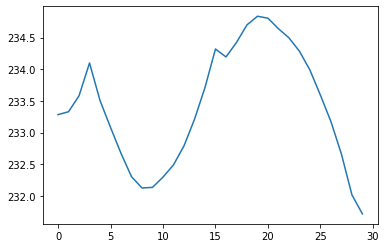

In [5]:
X_features = data_features['X_train_python_features_collection']
plt.plot(X_features[5,2,:,1])
plt.show()

In [6]:
pore_data = pd.read_csv('In718 Sample Information.csv') 
max_pore_area = pore_data['Max Pore Area'].to_numpy()
y = max_pore_area.reshape(240,1)
y.shape

(240, 1)

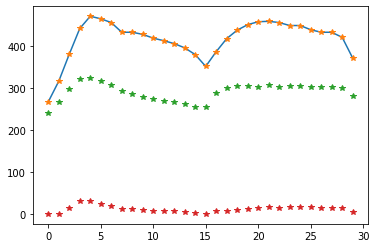

(240, 5, 30, 3)

In [7]:
X_features_trimmed = X_features[:,:,:,[0,1,2]]
plt.plot(X_features[239,2,:,0])
plt.plot(X_features_trimmed[239,2,:],'*')
plt.show()
X_features_trimmed.shape

In [8]:
data_features_4Folds = mat73.loadmat('X_train_python_features_collection_4Folds.mat')
data_features_4Folds.keys()

dict_keys(['X_Q1', 'X_Q2', 'X_Q3', 'X_Q4', 'class', 'y_Q1', 'y_Q2', 'y_Q3', 'y_Q4'])

In [9]:
classes = data_features_4Folds['class']
classes.shape

(240,)

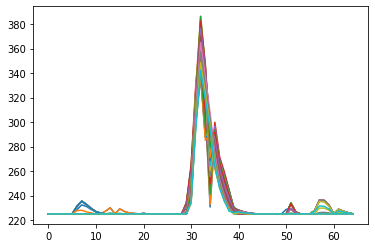

In [10]:
data_profiles = mat73.loadmat('X_train_python_collection.mat')
X_profiles = data_profiles['X_train_python_collection']
plt.plot(X_profiles[5,2,:,:].T)
plt.show()

# Helper Functions

In [11]:
def prediction_results(cnn,X_test,y_test,X_train,y_train):
  test_predictions = cnn.predict(X_test)
  train_predictions = cnn.predict(X_train)

  predictionError = y_test - test_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_test)-np.min(y_test))
  rmse_wrt_mean = rmse/np.mean(y_test)

  print('For Test data--->\nRMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_test)-np.min(y_test),rmse_wrt_range,np.mean(y_test),rmse_wrt_mean))
  
  predictionError = y_train - train_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_train)-np.min(y_train))
  rmse_wrt_mean = rmse/np.mean(y_train)

  print('\nFor Train data--->\nRMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_train)-np.min(y_train),rmse_wrt_range,np.mean(y_train),rmse_wrt_mean))

  data_max = max(np.max(test_predictions), np.max(y_test),np.max(train_predictions), np.max(y_train))
  plt.plot(train_predictions,y_train,'b.')
  plt.plot(test_predictions,y_test,'r.')
  plt.legend(['test','train'])
  plt.plot([0,data_max],[0,data_max])
  plt.show()

def training_history_with_validation(training):
  plt.plot(training.history['loss'])
  plt.plot(training.history['val_loss'])
  plt.ylabel('loss')
  # plt.plot(training.history['root_mean_squared_error'])
  # plt.plot(training.history['val_root_mean_squared_error'])
  # plt.ylabel('root_mean_squared_error')
  plt.xlabel('epoch' )
  plt.legend(['train','dev'])
  plt.show()

def training_history(training):
  plt.plot(training.history['loss'])
  plt.ylabel('loss')
  # plt.plot(training.history['root_mean_squared_error'])
  # plt.ylabel('root_mean_squared_error')
  plt.xlabel('epoch' )
  plt.legend(['train'])
  plt.show()

# def plot_fitting_history(history,filename,dpi):
def plot_fitting_history(history):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  if epochs > 100: plt.xticks(np.arange(0, epochs + 1, step=int(epochs/100)*10))
  else: plt.xticks(np.arange(0, epochs + 1, step=5))
  if 'val_loss' in history.history.keys():
    plt.plot(epoch_data,history.history['val_loss'],'o--')
    plt.legend(['Training','Validation'])
  else:
    plt.legend(['Training'])
  # plt.savefig(filename, dpi=dpi)
  plt.show()

def accuracy_measure(predictions, true_value, percentage):
  scores = []
  for p,t in zip(predictions,true_value):
    if abs(p-t) < t*percentage:
      scores.append(1)
  print('Accuracy: {}% out of {} items'.format(round(sum(scores)/predictions.shape[0]*100,2), predictions.shape[0]))
  return round(sum(scores)/predictions.shape[0],4)

def combined_prediction_results(test_predictions,y_test):
  predictionError = y_test - test_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_test)-np.min(y_test))
  rmse_wrt_mean = rmse/np.mean(y_test)

  print('RMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_test)-np.min(y_test),rmse_wrt_range,np.mean(y_test),rmse_wrt_mean))
  
def combined_predictions_4Folds(X,Classifier_model,Q1_model,Q2_model,Q3_model,Q4_model):
  y_test_pred = Classifier_model.predict(X)
  Q1_test_predictions = Q1_model.predict(X)
  Q2_test_predictions = Q2_model.predict(X)
  Q3_test_predictions = Q3_model.predict(X)
  Q4_test_predictions = Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1_test_predictions,Q2_test_predictions,Q3_test_predictions,Q4_test_predictions), axis = 1)
  combined_test_predictions1 = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  combined_test_predictions2 = np.sum(np.multiply(Q_test_predictions,np.round(y_test_pred,0)), axis = 1)

  return combined_test_predictions1, combined_test_predictions2

def combined_predictions_2Folds(X,Classifier_model,Q1Q2_model,Q3Q4_model):
  y_test_pred = Classifier_model.predict(X)
  Q1Q2_test_predictions = Q1Q2_model.predict(X)
  Q3Q4_test_predictions = Q3Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1Q2_test_predictions,Q3Q4_test_predictions), axis = 1)
  combined_test_predictions1 = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  combined_test_predictions2 = np.sum(np.multiply(Q_test_predictions,np.round(y_test_pred,0)), axis = 1)

  return combined_test_predictions1, combined_test_predictions2

# k-fold preparation

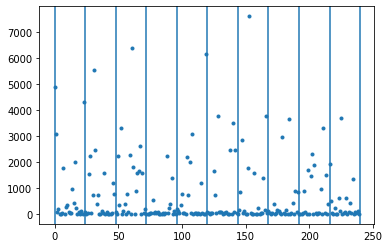

In [12]:
indexes = np.array([  4, 233,  81, 204, 116, 128, 129, 217, 150, 180, 154,  50, 177,
       155,  41,   1, 232, 221, 166, 189,  57,  51, 156,  15,  85, 126,
       178, 206, 212,  94, 239,  30, 234,  42, 218, 121, 161,  99, 197,
        14, 140,  74, 144, 102, 179,  69, 237,  21, 119,  67, 231, 210,
        37, 137,  52, 216, 183, 202, 199,   9, 162,  27, 219, 115, 220,
       223,  34, 227, 113,   7, 171,  63, 185, 136, 158, 132, 141,  19,
       109, 133, 172,  97, 152,  56,  58,  48, 170,  65, 228, 167, 191,
         3, 214,  39, 105,  73, 182,  54, 123, 130,  28, 127,  60,  49,
       236,   0,  20, 148,   8, 111,  78,  53, 138,  79, 143, 207,  35,
       169, 168,  12,  89,  92,  93, 108,  68, 222,  26,  72,  24,  84,
       203,  64, 110,  55,  90,  46,  59, 147,  11, 157,  13,  91, 215,
       103, 131, 175, 225,  10,  71,  66, 114, 101,   5,  16, 192, 142,
       184,  45, 122, 186,  17, 173,  95,  86,  36,  82,  25,  61,  96,
       104,  87, 164, 188,  75, 200, 198,  62,  80, 124, 226, 165, 195,
        18, 112,  40, 153, 118, 213, 159, 201,  47, 229, 107, 181, 135,
        83,   6, 187, 145, 208, 174, 205,   2, 149,  23, 190, 117, 100,
       139, 230, 163,  38,  77, 235, 146,  31, 238, 224, 160, 151,  22,
       176, 134,  33,  43,  29, 194,  76, 106, 211, 120,  70,  32,  98,
       209, 125, 193,  44,  88, 196])
y_shuffled = y[indexes]
plt.plot(y_shuffled,'.')
for i in np.linspace(0,240,11):
  plt.axvline(i)
plt.show()
# indexes

In [13]:
np.arange(0,240,24)

array([  0,  24,  48,  72,  96, 120, 144, 168, 192, 216])

In [14]:
test_indexes_dictionary = {}
counter = 1
for i in np.arange(0,240,24):
  i = int(i)
  key_name = 'test_data_' + str(counter) + '_indexes'
  test_indexes_dictionary.update({key_name: indexes[i:i+24]})
  counter = counter + 1

In [15]:
test_indexes_dictionary.keys()

dict_keys(['test_data_1_indexes', 'test_data_2_indexes', 'test_data_3_indexes', 'test_data_4_indexes', 'test_data_5_indexes', 'test_data_6_indexes', 'test_data_7_indexes', 'test_data_8_indexes', 'test_data_9_indexes', 'test_data_10_indexes'])

In [16]:
test_indexes_dictionary['test_data_1_indexes'], \
test_indexes_dictionary['test_data_2_indexes'], \
test_indexes_dictionary['test_data_3_indexes'],

(array([  4, 233,  81, 204, 116, 128, 129, 217, 150, 180, 154,  50, 177,
        155,  41,   1, 232, 221, 166, 189,  57,  51, 156,  15]),
 array([ 85, 126, 178, 206, 212,  94, 239,  30, 234,  42, 218, 121, 161,
         99, 197,  14, 140,  74, 144, 102, 179,  69, 237,  21]),
 array([119,  67, 231, 210,  37, 137,  52, 216, 183, 202, 199,   9, 162,
         27, 219, 115, 220, 223,  34, 227, 113,   7, 171,  63]))

In [17]:
train_indexes_dictionary = {}
counter = 1
for key in test_indexes_dictionary.keys():
  key_name = 'train_data_' + str(counter) + '_indexes'
  train_indexes = []
  for _, num in enumerate(indexes):
    if num not in test_indexes_dictionary[key]:
      train_indexes.append(num)
  train_indexes = np.array(train_indexes)
  train_indexes_dictionary.update({key_name: train_indexes})
  counter = counter + 1

In [18]:
train_indexes_dictionary.keys()

dict_keys(['train_data_1_indexes', 'train_data_2_indexes', 'train_data_3_indexes', 'train_data_4_indexes', 'train_data_5_indexes', 'train_data_6_indexes', 'train_data_7_indexes', 'train_data_8_indexes', 'train_data_9_indexes', 'train_data_10_indexes'])

In [19]:
train_indexes_dictionary['train_data_2_indexes']

array([  4, 233,  81, 204, 116, 128, 129, 217, 150, 180, 154,  50, 177,
       155,  41,   1, 232, 221, 166, 189,  57,  51, 156,  15, 119,  67,
       231, 210,  37, 137,  52, 216, 183, 202, 199,   9, 162,  27, 219,
       115, 220, 223,  34, 227, 113,   7, 171,  63, 185, 136, 158, 132,
       141,  19, 109, 133, 172,  97, 152,  56,  58,  48, 170,  65, 228,
       167, 191,   3, 214,  39, 105,  73, 182,  54, 123, 130,  28, 127,
        60,  49, 236,   0,  20, 148,   8, 111,  78,  53, 138,  79, 143,
       207,  35, 169, 168,  12,  89,  92,  93, 108,  68, 222,  26,  72,
        24,  84, 203,  64, 110,  55,  90,  46,  59, 147,  11, 157,  13,
        91, 215, 103, 131, 175, 225,  10,  71,  66, 114, 101,   5,  16,
       192, 142, 184,  45, 122, 186,  17, 173,  95,  86,  36,  82,  25,
        61,  96, 104,  87, 164, 188,  75, 200, 198,  62,  80, 124, 226,
       165, 195,  18, 112,  40, 153, 118, 213, 159, 201,  47, 229, 107,
       181, 135,  83,   6, 187, 145, 208, 174, 205,   2, 149,  2

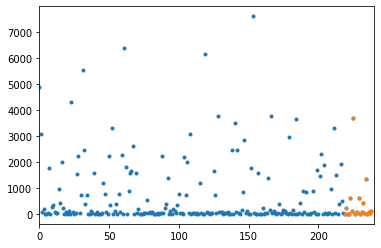

In [20]:
test_indexes = np.arange(0,239)
train = y_shuffled[0:-1]
plt.plot(test_indexes,train,'.')

test_indexes = np.arange(219,239)
train = y_shuffled[-21:-1]
plt.plot(test_indexes,train,'.')

plt.xlim([0,240])
plt.show()

In [21]:
folds = 10
items_per_fold = int(len(y)/folds)

# Functions for different Models

In [22]:
def get_regression_model(X_train, y_train, num_features):

  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(0)
  rn.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  from keras import backend as K
  tf.random.set_seed(1234)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

  feature_regression_model = models.Sequential([

      layers.SeparableConv2D(filters=2**9, kernel_size=2, padding = 'same', activation='relu', input_shape=(5, 30, num_features)),
      layers.MaxPooling2D(2),
      layers.BatchNormalization(),
      
      layers.SeparableConv2D(filters=2**8, kernel_size=2, padding = 'same', activation='relu'),
      layers.MaxPooling2D((2)),
      
      layers.SeparableConv2D(filters=2**7, kernel_size=2, padding = 'same', activation='relu'),
      layers.BatchNormalization(),
          
      layers.Flatten(),
      layers.Dense(2**10, activation='relu'),
      layers.Dense(2**9, activation='relu'),
      layers.Dense(1, activation='relu')
  ])

  learning_rate = 0.0001
  feature_regression_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss='MeanAbsoluteError')

  early_callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
  training = feature_regression_model.fit(X_train, y_train, epochs=1000, batch_size=16, shuffle=True, callbacks = early_callbacks, verbose=0)

  return feature_regression_model, training

def get_classifier_model(X_train, classes_train):

  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(0)
  rn.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  from keras import backend as K
  tf.random.set_seed(1234)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

  classifier_model = models.Sequential([

      layers.SeparableConv2D(filters=2**5, kernel_size=2, padding = 'same', activation='relu', input_shape=(5, 30, 3)),
      layers.MaxPooling2D(2),
      layers.BatchNormalization(),
      
      layers.SeparableConv2D(filters=2**4, kernel_size=2, padding = 'same', activation='relu'),
      layers.MaxPooling2D((2)),
      
      layers.SeparableConv2D(filters=2**3, kernel_size=2, padding = 'same', activation='relu'),
      layers.BatchNormalization(),

      # layers.SeparableConv2D(filters=16, kernel_size=2, padding = 'same', activation='relu', input_shape=(5, 30, 3)),
      # layers.BatchNormalization(),
      # layers.SeparableConv2D(filters=16, kernel_size=2, padding = 'same', activation='relu'),
      # layers.BatchNormalization(),
      # layers.MaxPooling2D(2),
      # layers.Dropout(0.25),
      
      # layers.SeparableConv2D(filters=32, kernel_size=2, padding = 'same', activation='relu'),
      # layers.BatchNormalization(),
      # layers.SeparableConv2D(filters=32, kernel_size=2, padding = 'same', activation='relu'),
      # layers.BatchNormalization(),
      # layers.MaxPooling2D(2),
      # layers.Dropout(0.25),
          
      layers.Flatten(),
      layers.Dense(2**6, activation='relu'),
      # layers.Dropout(0.5),
      layers.Dense(2**5, activation='relu'),
      # layers.Dropout(0.5),
      # layers.Dense(2**6, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
      layers.Dense(int(np.max(classes_train)+1), activation='softmax')
  ])

  learning_rate = 0.0001
  classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss='SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  classifier_training = classifier_model.fit(X_train, classes_train, epochs=500, batch_size=32, shuffle=True,
            validation_split = 0.2, callbacks = early_callbacks, verbose=0)

  # early_callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=20)
  # classifier_training = classifier_model.fit(X_train, classes_train, epochs=100, batch_size=16, shuffle=True, callbacks = early_callbacks, verbose=0)

  return classifier_model, classifier_training

def get_classificaion_results(classifier_model,X_test,classes_test):
  from sklearn.metrics import confusion_matrix , classification_report
  import numpy as np
  import seaborn as sn

  y_pred = classifier_model.predict(X_test)
  y_pred_classes = [np.argmax(element) for element in y_pred]

  # cm = tf.math.confusion_matrix(labels=classes_test,predictions=y_pred_classes)
  # plt.figure(figsize = (7,5))
  # sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  # plt.xlabel('Predicted');
  # plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(classes_test, y_pred_classes))

# k-fold Validation

In [23]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
for i in range(len(train_indexes_list)):
  print(train_indexes_list[i])

train_data_1_indexes
train_data_2_indexes
train_data_3_indexes
train_data_4_indexes
train_data_5_indexes
train_data_6_indexes
train_data_7_indexes
train_data_8_indexes
train_data_9_indexes
train_data_10_indexes


In [29]:
new_classes = np.ones(classes.shape)*-1
low_threshold = 10
medium_threshold = 80
low_pore_indexes = np.where(y<=low_threshold)[0]
medium_pore_indexes = np.where((y>low_threshold) & (y<=medium_threshold))[0]
large_pore_indexes = np.where(y>medium_threshold)[0]
new_classes[low_pore_indexes] = 0
new_classes[medium_pore_indexes] = 1
new_classes[large_pore_indexes] = 2

In [30]:
np.where(y<=low_threshold)[0].shape, np.where((y>low_threshold) & \
        (y<=medium_threshold))[0].shape, np.where(y>medium_threshold)[0].shape

((39,), (94,), (107,))

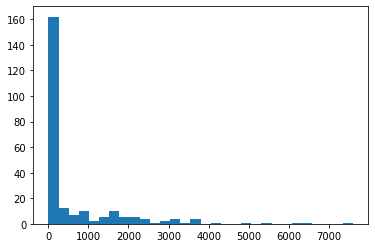

In [31]:
plt.hist(y, bins=30)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

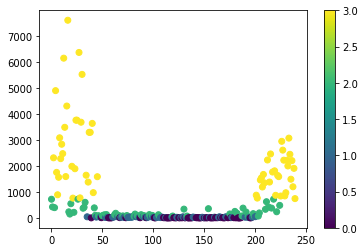

In [32]:
plt.scatter(range(y.shape[0]),y,c=classes)
plt.colorbar()
plt.show

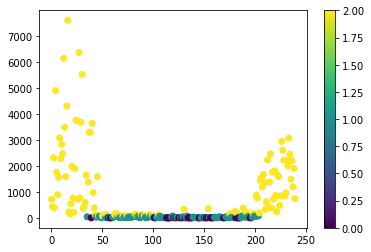

In [33]:
plt.scatter(range(y.shape[0]),y,c=new_classes)
plt.colorbar()

# Classification Model


Round: 1


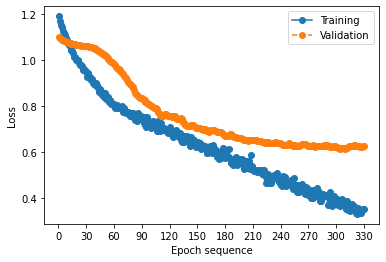

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.77      0.83        35
         1.0       0.88      0.86      0.87        87
         2.0       0.88      0.95      0.91        94

    accuracy                           0.88       216
   macro avg       0.89      0.86      0.87       216
weighted avg       0.88      0.88      0.88       216

Testing Results
1/1 [==============================] - 0s 21ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         4
         1.0       0.56      0.71      0.63         7
         2.0       0.83      0.77      0.80        13

    accuracy                           0.71        24
   macro avg       0.69      0.66      0.67        24
weighted avg       0.72      0.71      0.71        24





Round: 2


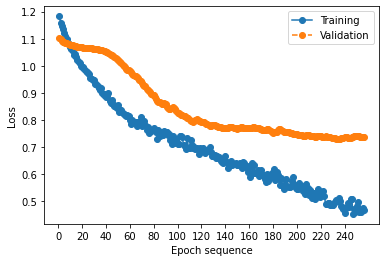

Training Results
7/7 [==============================] - 0s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.75      0.41      0.53        37
         1.0       0.78      0.82      0.80        84
         2.0       0.81      0.92      0.86        95

    accuracy                           0.79       216
   macro avg       0.78      0.71      0.73       216
weighted avg       0.79      0.79      0.78       216

Testing Results
1/1 [==============================] - 0s 18ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.56      0.50      0.53        10
         2.0       0.77      0.83      0.80        12

    accuracy                           0.62        24
   macro avg       0.44      0.44      0.44        24
weighted avg       0.62      0.62      0.62        24





Round: 3


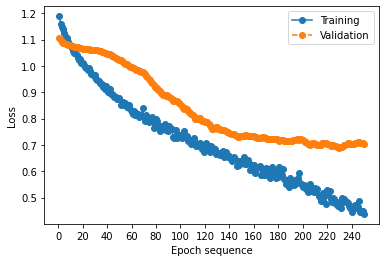

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.37      0.51        35
         1.0       0.78      0.90      0.83        89
         2.0       0.87      0.91      0.89        92

    accuracy                           0.82       216
   macro avg       0.82      0.73      0.74       216
weighted avg       0.82      0.82      0.80       216

Testing Results
1/1 [==============================] - 0s 18ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.44      0.80      0.57         5
         2.0       0.87      0.87      0.87        15

    accuracy                           0.71        24
   macro avg       0.44      0.56      0.48        24
weighted avg       0.63      0.71      0.66        24





Round: 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


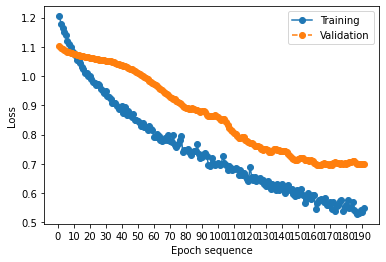

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.69      0.35      0.47        31
         1.0       0.71      0.85      0.77        84
         2.0       0.88      0.87      0.88       101

    accuracy                           0.79       216
   macro avg       0.76      0.69      0.71       216
weighted avg       0.79      0.79      0.78       216

Testing Results
1/1 [==============================] - 0s 25ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.50      0.12      0.20         8
         1.0       0.62      0.80      0.70        10
         2.0       0.56      0.83      0.67         6

    accuracy                           0.58        24
   macro avg       0.56      0.59      0.52        24
weighted avg       0.56      0.58      0.52        24





Round: 5


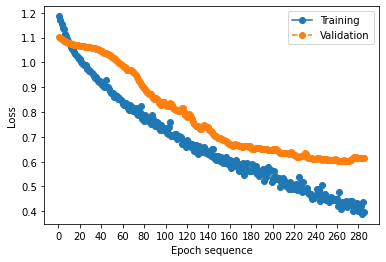

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.62      0.72        37
         1.0       0.82      0.87      0.84        82
         2.0       0.87      0.92      0.89        97

    accuracy                           0.85       216
   macro avg       0.85      0.80      0.82       216
weighted avg       0.85      0.85      0.84       216

Testing Results
1/1 [==============================] - 0s 20ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.73      0.67      0.70        12
         2.0       0.73      0.80      0.76        10

    accuracy                           0.67        24
   macro avg       0.48      0.49      0.49        24
weighted avg       0.67      0.67      0.67        24





Round: 6


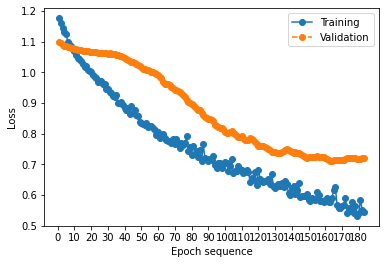

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.24      0.38        37
         1.0       0.69      0.88      0.77        82
         2.0       0.87      0.92      0.89        97

    accuracy                           0.79       216
   macro avg       0.82      0.68      0.68       216
weighted avg       0.81      0.79      0.76       216

Testing Results
1/1 [==============================] - 0s 19ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.62      0.67      0.64        12
         2.0       0.56      0.50      0.53        10

    accuracy                           0.54        24
   macro avg       0.39      0.39      0.39        24
weighted avg       0.54      0.54      0.54        24





Round: 7


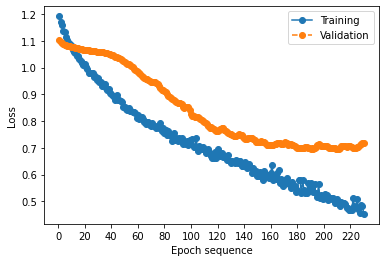

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.70      0.41      0.52        34
         1.0       0.76      0.85      0.80        86
         2.0       0.87      0.91      0.89        96

    accuracy                           0.81       216
   macro avg       0.78      0.72      0.74       216
weighted avg       0.80      0.81      0.80       216

Testing Results
1/1 [==============================] - 0s 18ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.46      0.75      0.57         8
         2.0       0.80      0.73      0.76        11

    accuracy                           0.58        24
   macro avg       0.42      0.49      0.44        24
weighted avg       0.52      0.58      0.54        24





Round: 8


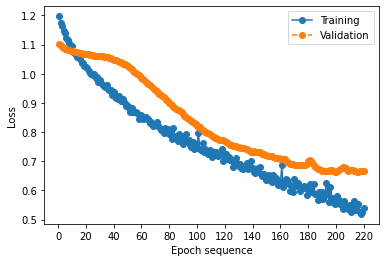

Training Results
7/7 [==============================] - 0s 4ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.75      0.17      0.27        36
         1.0       0.69      0.82      0.75        83
         2.0       0.81      0.92      0.86        97

    accuracy                           0.75       216
   macro avg       0.75      0.63      0.63       216
weighted avg       0.75      0.75      0.72       216

Testing Results
1/1 [==============================] - 0s 30ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.64      0.64      0.64        11
         2.0       0.80      0.80      0.80        10

    accuracy                           0.62        24
   macro avg       0.48      0.48      0.48        24
weighted avg       0.62      0.62      0.63        24





Round: 9


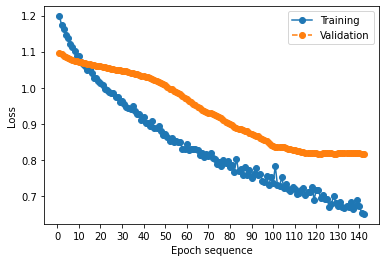

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        34
         1.0       0.66      0.80      0.72        84
         2.0       0.75      0.88      0.81        98

    accuracy                           0.71       216
   macro avg       0.47      0.56      0.51       216
weighted avg       0.60      0.71      0.65       216

Testing Results
1/1 [==============================] - 0s 34ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      0.70      0.64        10
         2.0       0.75      1.00      0.86         9

    accuracy                           0.67        24
   macro avg       0.44      0.57      0.50        24
weighted avg       0.52      0.67      0.59        24





Round: 10


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


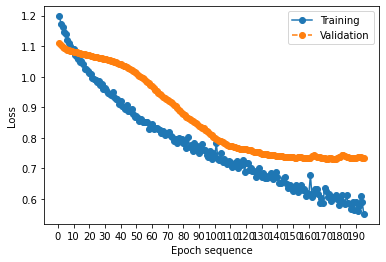

Training Results
7/7 [==============================] - 0s 3ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.43      0.09      0.14        35
         1.0       0.68      0.81      0.74        85
         2.0       0.81      0.91      0.85        96

    accuracy                           0.74       216
   macro avg       0.64      0.60      0.58       216
weighted avg       0.70      0.74      0.69       216

Testing Results
1/1 [==============================] - 0s 19ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.58      0.78      0.67         9
         2.0       0.75      0.82      0.78        11

    accuracy                           0.67        24
   macro avg       0.44      0.53      0.48        24
weighted avg       0.56      0.67      0.61        24






/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
test_accuracy_list1 = []
train_accuracy_list1 = []
test_accuracy_list2 = []
train_accuracy_list2 = []
for i in range(len(train_indexes_list)):

  print('\nRound:',str(i+1))
  X_train = X_features_trimmed[train_indexes_dictionary[train_indexes_list[i]]]
  y_train = y[train_indexes_dictionary[train_indexes_list[i]]]
  # classes_train = classes[train_indexes_dictionary[train_indexes_list[i]]]
  classes_train = new_classes[train_indexes_dictionary[train_indexes_list[i]]]

  X_test = X_features_trimmed[test_indexes_dictionary[test_indexes_list[i]]]
  y_test = y[test_indexes_dictionary[test_indexes_list[i]]]
  # classes_test = classes[test_indexes_dictionary[test_indexes_list[i]]]
  classes_test = new_classes[test_indexes_dictionary[test_indexes_list[i]]]

  classifier_model, classifier_training = get_classifier_model(X_train, classes_train)
  plt.figure()
  plot_fitting_history(classifier_training)
  print('Training Results\n=================')
  get_classificaion_results(classifier_model,X_train,classes_train)
  print('Testing Results\n=================')
  get_classificaion_results(classifier_model,X_test,classes_test)
  print('\n\n')

# 4-folds Regression Model


Round: 1
1/1 [==============================] - 0s 140ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         6
         1.0       0.40      0.67      0.50         3
         2.0       0.60      0.33      0.43         9
         3.0       0.62      0.83      0.71         6

    accuracy                           0.58        24
   macro avg       0.57      0.62      0.58        24
weighted avg       0.60      0.58      0.57        24

1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 94ms/step
Accuracy: 4.17% out of 24 items
Accuracy: 8.33% out of 24 items
7/7 [==============================] - 0s 4ms/step
Accuracy: 82.41% out of 216 items
Accuracy: 82.41% out of 216 items

Round: 2
1/1 [==============================] - 0s 90ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.71      0.83      0.77         6
         1.0       0.43      0.60      0.50         5
         2.0       0.00      0.00      0.00         5
         3.0       0.86      0.75      0.80         8

    accuracy                           0.58        24
   macro avg       0.50      0.55      0.52        24
weighted avg       0.55      0.58      0.56        24

1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 94ms/step
Accuracy: 8.33% out of 24 items
Accuracy: 12.5% out of 24 items
7/7 [==============================] - 0s 2ms/step
Accuracy: 89.35% out of 216 items
Accuracy: 89.35% out of 216 items

Round: 3
1/1 [==============================] - 0s 93ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.57      0.67      0.62         6
         1.0       0.25      1.00      0.40         1
         2.0       0.00      0.00      0.00         6
         3.0       0.82      0.82      0.82        11

    accuracy                           0.58        24
   macro avg       0.41      0.62      0.46        24
weighted avg       0.53      0.58      0.55        24

1/1 [==============================] - 0s 90ms/step
Accuracy: 4.17% out of 24 items
Accuracy: 8.33% out of 24 items
7/7 [==============================] - 0s 3ms/step
Accuracy: 83.8% out of 216 items
Accuracy: 83.8% out of 216 items

Round: 4


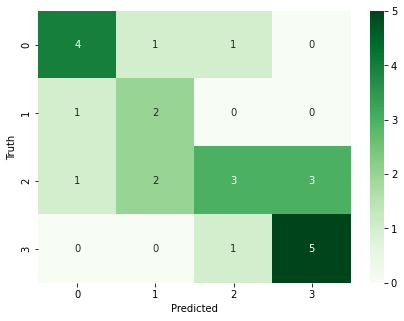

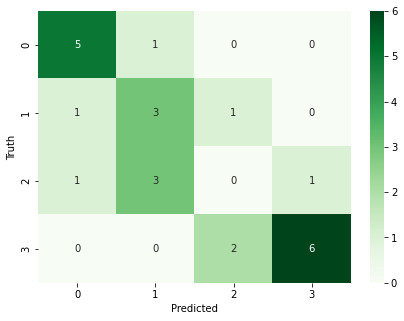

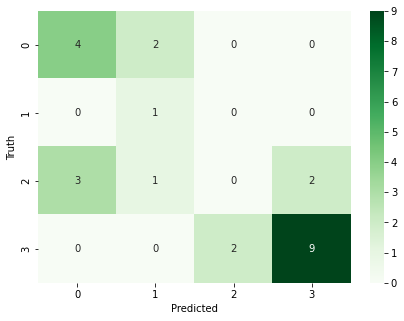

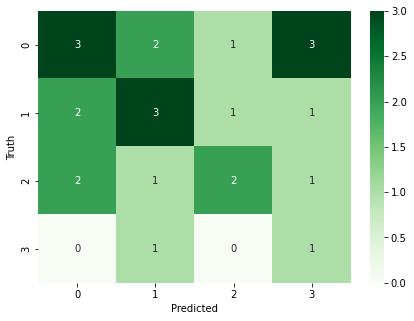

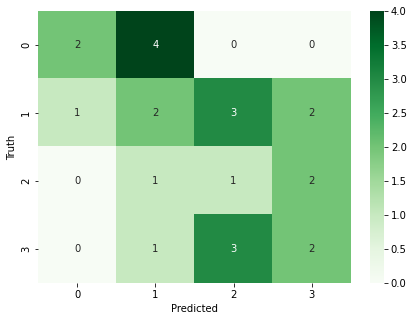

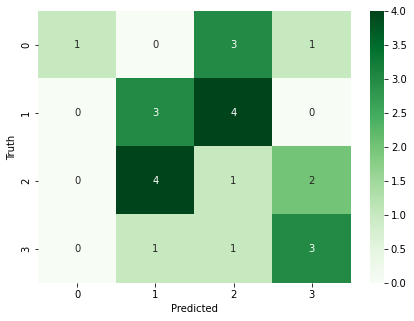

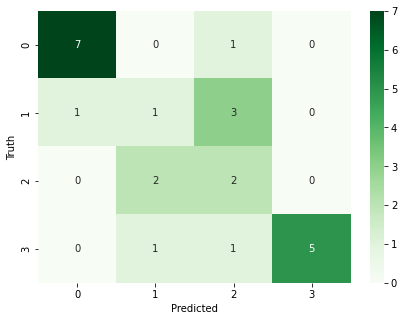

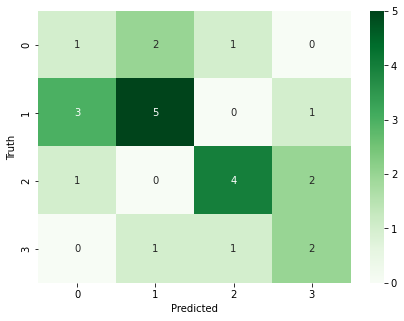

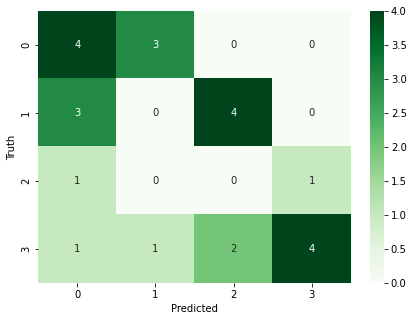

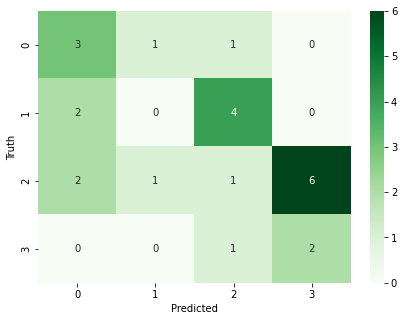

In [ ]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
test_accuracy_list1 = []
train_accuracy_list1 = []
test_accuracy_list2 = []
train_accuracy_list2 = []
for i in range(len(train_indexes_list)):

  print('\nRound:',str(i+1))
  X_train = X_features_trimmed[train_indexes_dictionary[train_indexes_list[i]]]
  y_train = y[train_indexes_dictionary[train_indexes_list[i]]]
  classes_train = classes[train_indexes_dictionary[train_indexes_list[i]]]

  X_test = X_features_trimmed[test_indexes_dictionary[test_indexes_list[i]]]
  y_test = y[test_indexes_dictionary[test_indexes_list[i]]]
  classes_test = classes[test_indexes_dictionary[test_indexes_list[i]]]

  classifier_model, classifier_training = get_classifier_model(X_train, classes_train)
  get_classificaion_results(classifier_model,X_test,classes_test)

  Q1_indexes = np.where(y_train <= np.percentile(y_train,25))[0]
  X_train_Q1 = X_train[Q1_indexes]
  y_train_Q1 = y_train[Q1_indexes]
  feature_regression_model_Q1, training_Q1 = get_regression_model(X_train_Q1, y_train_Q1, 3)

  Q2_indexes = np.where((y_train <= np.percentile(y_train,50)) & (y_train > np.percentile(y_train,25)))[0]
  X_train_Q2 = X_train[Q2_indexes]
  y_train_Q2 = y_train[Q2_indexes]
  feature_regression_model_Q2, training_Q2 = get_regression_model(X_train_Q2, y_train_Q2, 3)

  Q3_indexes = np.where((y_train <= np.percentile(y_train,75)) & (y_train > np.percentile(y_train,50)))[0]
  X_train_Q3 = X_train[Q3_indexes]
  y_train_Q3 = y_train[Q3_indexes]
  feature_regression_model_Q3, training_Q3 = get_regression_model(X_train_Q3, y_train_Q3, 3)

  Q4_indexes = np.where((y_train <= np.percentile(y_train,100)) & (y_train > np.percentile(y_train,75)))[0]
  X_train_Q4 = X_train[Q4_indexes]
  y_train_Q4 = y_train[Q4_indexes]
  feature_regression_model_Q4, training_Q4 = get_regression_model(X_train_Q4, y_train_Q4, 3)

  combined_test_predictions1, combined_test_predictions2 = \
  combined_predictions_4Folds(X_test,classifier_model,feature_regression_model_Q1,\
                              feature_regression_model_Q2,feature_regression_model_Q3,feature_regression_model_Q4)


  test_accuracy1 = accuracy_measure(combined_test_predictions1,y_test,0.1)
  test_accuracy2 = accuracy_measure(combined_test_predictions2,y_test,0.1)
  test_accuracy_list1.append(test_accuracy1)
  test_accuracy_list2.append(test_accuracy2)

  combined_train_predictions1, combined_train_predictions2 = \
  combined_predictions_4Folds(X_train,classifier_model,feature_regression_model_Q1,\
                              feature_regression_model_Q2,feature_regression_model_Q3,feature_regression_model_Q4)  
  train_accuracy1 = accuracy_measure(combined_train_predictions1,y_train,0.1)
  train_accuracy2 = accuracy_measure(combined_train_predictions1,y_train,0.1)
  train_accuracy_list1.append(train_accuracy1)  
  train_accuracy_list2.append(train_accuracy2)

In [ ]:
kFold_test_accuracy1 = round(np.mean(np.array(test_accuracy_list1)),4)
kFold_test_accuracy2 = round(np.mean(np.array(test_accuracy_list2)),4)
kFold_train_accuracy1 = round(np.mean(np.array(train_accuracy_list1)),4)
kFold_train_accuracy2 = round(np.mean(np.array(train_accuracy_list2)),4)
kFold_test_accuracy1, kFold_train_accuracy1, kFold_test_accuracy2, kFold_train_accuracy2

(0.0667, 0.8671, 0.0708, 0.8671)

# Feature Regression Model

In [ ]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
test_accuracy_list = []
train_accuracy_list = []
for i in range(len(train_indexes_list)):
  print('\nRound:',str(i+1))
  X_train = X_features_trimmed[train_indexes_dictionary[train_indexes_list[i]]]
  y_train = y[train_indexes_dictionary[train_indexes_list[i]]]

  X_test = X_features_trimmed[test_indexes_dictionary[test_indexes_list[i]]]
  y_test = y[test_indexes_dictionary[test_indexes_list[i]]]  

  feature_regression_model, training = get_regression_model(X_train, y_train, 3)

  test_accuracy = accuracy_measure(feature_regression_model.predict(X_test),y_test,0.1)
  train_accuracy = accuracy_measure(feature_regression_model.predict(X_train),y_train,0.1)
  # prediction_results(feature_regression_model,X_test,y_test,X_train,y_train)
  # training_history(training)
  test_accuracy_list.append(test_accuracy)
  train_accuracy_list.append(train_accuracy)


Round: 1
1/1 [==============================] - 0s 93ms/step
Accuracy: 0.0% out of 24 items
7/7 [==============================] - 0s 2ms/step
Accuracy: 68.98% out of 216 items

Round: 2
1/1 [==============================] - 0s 92ms/step
Accuracy: 12.5% out of 24 items
7/7 [==============================] - 0s 2ms/step
Accuracy: 62.5% out of 216 items

Round: 3
1/1 [==============================] - 0s 89ms/step
Accuracy: 0.0% out of 24 items
7/7 [==============================] - 0s 3ms/step
Accuracy: 55.09% out of 216 items

Round: 4
1/1 [==============================] - 0s 100ms/step
Accuracy: 8.33% out of 24 items
7/7 [==============================] - 0s 2ms/step
Accuracy: 60.65% out of 216 items

Round: 5
1/1 [==============================] - 0s 92ms/step
Accuracy: 4.17% out of 24 items
7/7 [==============================] - 0s 2ms/step
Accuracy: 45.83% out of 216 items

Round: 6
1/1 [==============================] - 0s 96ms/step
Accuracy: 4.17% out of 24 items
7/7 [========

In [ ]:
kFold_test_accuracy = round(np.mean(np.array(test_accuracy_list)),4)
kFold_train_accuracy = round(np.mean(np.array(train_accuracy_list)),4)
kFold_test_accuracy, kFold_train_accuracy

(0.0625, 0.5861)

In [ ]:
# feature_regression_model.save('MSE596ACNN_CrossValidated_FeaturesModel.h5')

# Profile Regression Model

In [ ]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
test_accuracy_list = []
train_accuracy_list = []
for i in range(len(train_indexes_list)):
  print('\nRound:',str(i+1))
  X_train = X_profiles[train_indexes_dictionary[train_indexes_list[i]]]
  y_train = y[train_indexes_dictionary[train_indexes_list[i]]]

  X_test = X_profiles[test_indexes_dictionary[test_indexes_list[i]]]
  y_test = y[test_indexes_dictionary[test_indexes_list[i]]]

  profile_regression_model, training = get_regression_model(X_train, y_train, 65)
  
  test_accuracy = accuracy_measure(profile_regression_model.predict(X_test),y_test,0.1)
  train_accuracy = accuracy_measure(profile_regression_model.predict(X_train),y_train,0.1)
  # prediction_results(profile_regression_model,X_test,y_test,X_train,y_train)
  # training_history(training)
  test_accuracy_list.append(test_accuracy)
  train_accuracy_list.append(train_accuracy)


Round: 1
1/1 [==============================] - 0s 106ms/step
Accuracy: 8.33% out of 24 items
7/7 [==============================] - 0s 3ms/step
Accuracy: 39.81% out of 216 items

Round: 2
1/1 [==============================] - 0s 90ms/step
Accuracy: 0.0% out of 24 items
7/7 [==============================] - 0s 3ms/step
Accuracy: 33.33% out of 216 items

Round: 3
1/1 [==============================] - 0s 93ms/step
Accuracy: 4.17% out of 24 items
7/7 [==============================] - 0s 3ms/step
Accuracy: 36.57% out of 216 items

Round: 4
1/1 [==============================] - 0s 98ms/step
Accuracy: 8.33% out of 24 items
7/7 [==============================] - 0s 3ms/step
Accuracy: 50.93% out of 216 items

Round: 5
1/1 [==============================] - 0s 95ms/step
Accuracy: 4.17% out of 24 items
7/7 [==============================] - 0s 3ms/step
Accuracy: 49.07% out of 216 items

Round: 6
1/1 [==============================] - 0s 93ms/step
Accuracy: 0.0% out of 24 items
7/7 [=======

In [ ]:
kFold_test_accuracy = round(np.mean(np.array(test_accuracy_list)),4)
kFold_train_accuracy = round(np.mean(np.array(train_accuracy_list)),4)
kFold_test_accuracy, kFold_train_accuracy

(0.0458, 0.4148)

In [ ]:
# profile_regression_model.save('MSE596ACNN_CrossValidated_ProfilesModel.h5')